# text emojification

Here we build a RNN model (using LSTM) for suggesting emojies against sentences.

> Inspired by: [Sequence Models](https://www.coursera.org/learn/nlp-sequence-models).

In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import OrderedDict

import os, sys
sys.path.append(os.sep.join(["..", "data"]))
from loaders.emojify_text import EmojifyText

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"PyTorch using device: {device}")

model_path = os.sep.join(["..", "data", "models", "w3-text-emojify.pth"])

PyTorch using device: cuda


## # word-embeddings
Here we are loading word-embeddings trained using GloVe. Each word embedded as a 100-dimensional vector.

In [2]:
glove_file = '../data/models/glove.6B.100d.txt'

n_x = 100
num_classes = 5
embeddings = list()
embeddings.append(torch.zeros(size=(1,n_x)))

empty_word = ' '
words_to_index = {empty_word: 0}
index_to_words = {0: empty_word}

with open(glove_file, 'r', encoding="utf8") as f:
    i = 1
    for line in f:
        embeddings.append(None) # populates the i^th index

        line = line.strip().split()
        curr_word = line[0]

        words_to_index[curr_word] = i
        index_to_words[i] = curr_word
        embeddings[i] = torch.reshape(
            input=torch.Tensor(np.array(line[1:], dtype=np.float64)),
            shape=(1,n_x))
        
        i += 1

embeddings = torch.cat(tensors=embeddings, dim=0)
assert embeddings.shape == (len(words_to_index), n_x), \
    "Error creating embedings tensor."

embeddings = torch.nn.Embedding.from_pretrained(
    embeddings=embeddings, freeze=True)

## # training-data
Here we load the training and test data-sets.

In [3]:
train_dataset = EmojifyText(is_train=True, word_to_index=words_to_index, 
    suffix_pad=empty_word, seq_length=None)
test_dataset = EmojifyText(is_train=False, word_to_index=words_to_index,
    suffix_pad=empty_word, seq_length=None)

[is_train: True] Sequence-length: 10
[is_train: False] Sequence-length: 8


## # forward-propagation

> **Note**: for forward propagation equations, read [Section-2, Back-propagation: LSTM](./backprop-lstm.pdf).

In [4]:
class Emojify(torch.nn.Module):
    def __init__(self, model_arch: dict, embeddings: nn.Embedding, pad_word_index: int) -> None:
        super(Emojify, self).__init__()

        self.pad_word_index = pad_word_index
        self.model_arch = model_arch
        self.module_dict = nn.ModuleDict({
            'embedding-l0': embeddings,
            'lstm-l1': nn.LSTM(
                input_size=model_arch['n_x'],
                hidden_size=model_arch['n_a'],
                num_layers=model_arch["L"],
                bias=True,
                batch_first=False,
                dropout=0.5),
            'linear-l2': nn.utils.skip_init(nn.Linear,
                in_features=model_arch['n_a'],
                out_features=model_arch['n_y'],
                bias=True),
            'activation-l2': nn.LogSoftmax(dim=1)
        })
        nn.init.xavier_uniform_(tensor=self.module_dict['linear-l2'].weight)
        nn.init.zeros_(tensor=self.module_dict['linear-l2'].bias)

    def forward(self, indices: torch.LongTensor, ac_0: tuple) -> torch.Tensor:
        """Performs forward propagation through the LSTM.

        indices: shape -> (m,T_x)
        ac_0: shape -> ((L, m, n_a), (L, m, n_a))
        """
        # shape -> (m,1)
        seq_lengths = torch.sum(
            torch.where(indices != self.pad_word_index, 1, 0), 
            dim=1).to(device='cpu')
        # shape -> (m,T_x,n_x)
        Xb = self.module_dict['embedding-l0'](indices)
        Xb = nn.utils.rnn.pack_padded_sequence(
            input=Xb, lengths=seq_lengths, batch_first=True,
            enforce_sorted=False)
        _, ac_T = self.module_dict['lstm-l1'](Xb, ac_0)

        # shape -> (m, n_a)
        a_T = ac_T[0][1,:,:]
        
        # shape -> (m, n_y)
        z_y = self.module_dict['linear-l2'](a_T)
        # shape -> (m, n_y)
        yh_t = self.module_dict['activation-l2'](z_y)

        return yh_t

In [5]:
model_arch = {
    'n_x': 100,
    'n_a': 128,
    'n_y': num_classes,
    'L': 2
}

model = Emojify(model_arch=model_arch, embeddings=embeddings, 
    pad_word_index=words_to_index[empty_word])
model.to(device=device)
print(model)

Emojify(
  (module_dict): ModuleDict(
    (embedding-l0): Embedding(400001, 100)
    (lstm-l1): LSTM(100, 128, num_layers=2, dropout=0.5)
    (linear-l2): Linear(in_features=128, out_features=5, bias=True)
    (activation-l2): LogSoftmax(dim=1)
  )
)


## # backward-propagation

> **Note**: for backward-propagation equations, read [Section-3](./backprop-lstm.pdf)

In [6]:
def evaluate_model(model: nn.Module, loss_func: nn.Module, test_data: Dataset, 
        batch_size: int, model_arch: dict):
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True)
    
    total_test_loss: float = 0
    test_correct_count: int = 0
    
    with torch.no_grad():
        model.eval() # set model in evaluation mode

        for batch, (Xb, Yb) in enumerate(test_loader):
            ac_0 = (torch.zeros(size=(model_arch["L"], Xb.shape[0], 
                        model_arch["n_a"]), device=device),
                    torch.zeros(size=(model_arch["L"], Xb.shape[0], 
                        model_arch["n_a"]), device=device))

            # movie them to CUDA if device == 'cuda'
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb, ac_0)
            loss = loss_func(pred, Yb)

            total_test_loss += loss.item() * len(Xb)
            test_correct_count += (torch.argmax(pred, dim=1) == Yb).sum().item()
    
    return total_test_loss / len(test_data), test_correct_count / len(test_data)

def visualize_training(train_accuracies: list, train_losses: list, 
        test_accuracies: list, test_losses: list):
    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(30,15))

    ax1 = axs[0]
    ax1.plot(np.array(train_accuracies) * 100, label="train-accuracy")
    ax1.plot(np.array(test_accuracies) * 100, label="test-accuracy")
    ax1.set_ylabel('accuracy -->')
    ax1.set_xlabel('epoch -->')
    ax1.legend()

    ax2 = axs[1]
    ax2.plot(train_losses, label="train-loss")
    ax2.plot(test_losses, label="test-loss")
    ax2.set_ylabel('loss -->')
    ax2.set_xlabel('epoch -->')
    ax2.legend()

    plt.show()

def learn_model(model_arch: dict, train_data: Dataset, test_data: Dataset, model: nn.Module,
        learning_rate: np.double, beta1: np.double, beta2: np.double, 
        epsilon: np.double, num_epochs: int, batch_size: int):
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    loss_func = nn.NLLLoss(reduction='mean') # compute the mean of the loss
    optimizer = torch.optim.Adam(params=model.parameters(), 
        lr=learning_rate, betas=[beta1, beta2], eps=epsilon)

    train_losses = list()
    train_accuracies = list()
    test_losses = list()
    test_accuracies = list()


    for e in tqdm(np.arange(start=0, stop=num_epochs, step=1)):
        epochal_train_loss: float = 0.0
        epochal_correct_count: int = 0

        model.train(mode=True)
        for batch, (Xb, Yb) in enumerate(train_loader):
            ac_0 = (torch.zeros(size=(model_arch["L"], Xb.shape[0], 
                        model_arch["n_a"]), device=device),
                    torch.zeros(size=(model_arch["L"], Xb.shape[0], 
                        model_arch["n_a"]), device=device))

            # move them to CUDA/CPU device
            Xb, Yb = Xb.to(device=device), Yb.to(device=device)

            pred = model(Xb, ac_0)
            loss = loss_func(pred, Yb) 

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # for debugging
            epochal_train_loss += loss.item() * len(Xb)
            epochal_correct_count += (
                torch.argmax(pred, dim=1) == Yb).sum().item()

        train_losses.append(epochal_train_loss / len(train_data))
        train_accuracies.append(epochal_correct_count / len(train_data))

        test_loss, test_accuracy = evaluate_model(
            model=model, model_arch=model_arch, test_data=test_data, 
            loss_func=loss_func, batch_size=batch_size)
        test_losses.append(test_loss)
        test_accuracies.append(test_accuracy)

    return model, train_losses,\
        train_accuracies, test_losses, test_accuracies

## # training-model

100%|██████████| 200/200 [00:07<00:00, 28.10it/s]


Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000127 



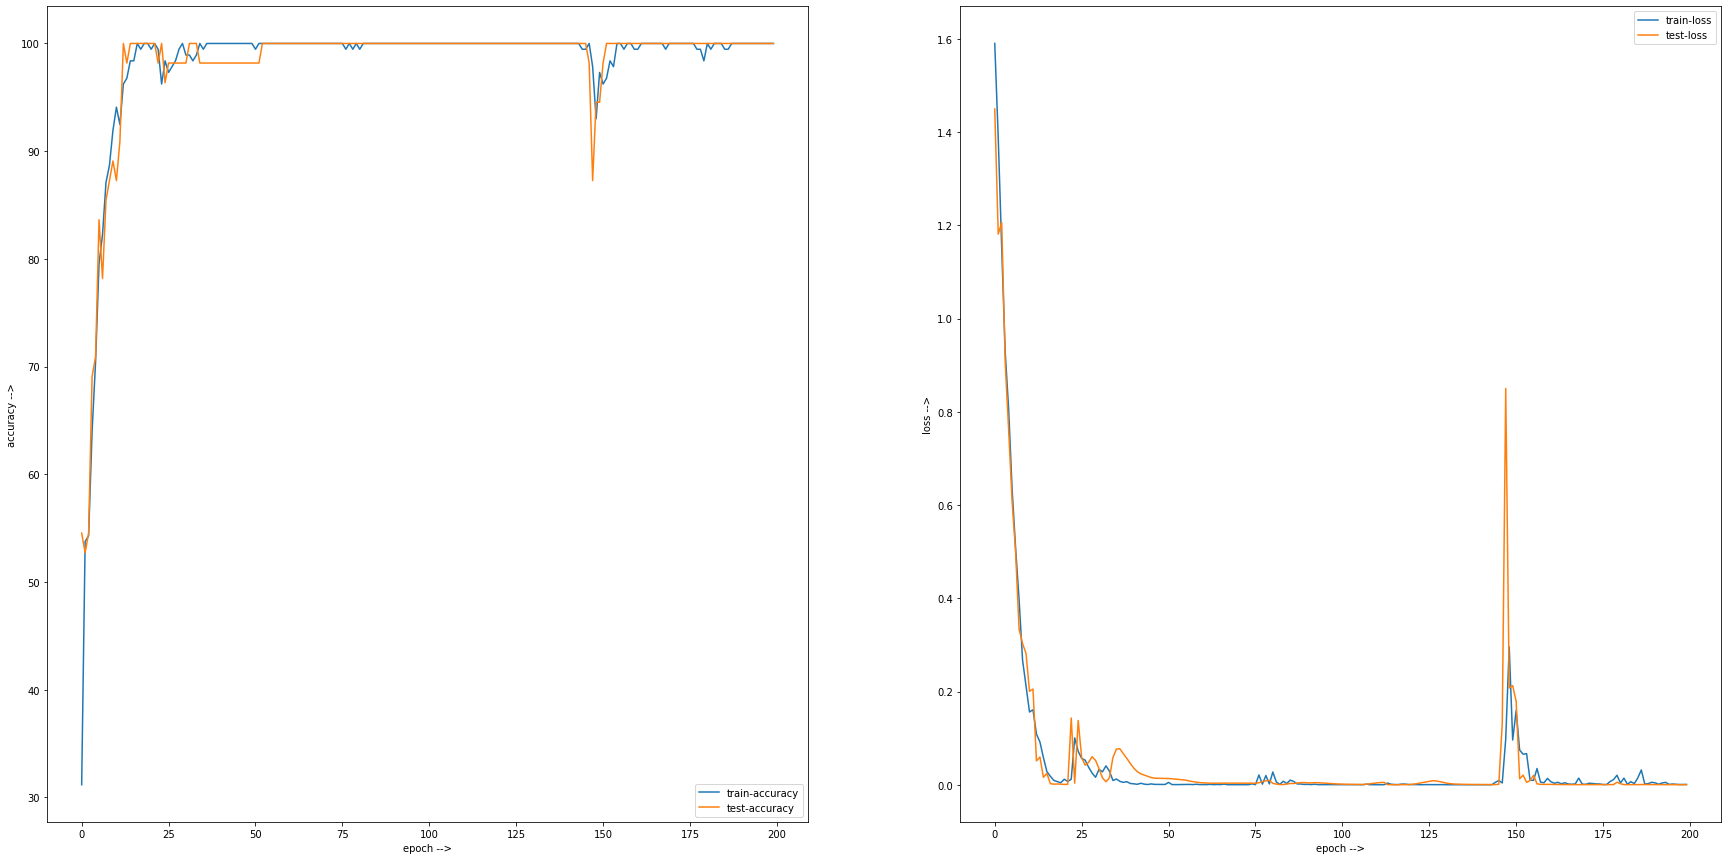

In [7]:
model, train_losses, train_accuracies, test_losses, test_accuracies = learn_model(
    train_data=train_dataset, test_data=test_dataset, model=model, 
    learning_rate=9e-3, beta1=0.9, beta2=0.999, epsilon=1e-08, 
    num_epochs=200, batch_size=64, model_arch=model_arch)

test_loss, test_accuracy = evaluate_model(model=model, test_data=test_dataset, 
    batch_size=64, loss_func=nn.NLLLoss(reduction='mean'), model_arch=model_arch)
print(f"Test Error: \n Accuracy: {(100*test_accuracy):>0.1f}%, Avg loss: {test_loss:>8f} \n")

visualize_training(train_accuracies=train_accuracies, train_losses=train_losses,
    test_accuracies=test_accuracies, test_losses=test_losses)

In [9]:
torch.save(model, model_path)

print(f"Model saved at: {model_path}")

Model saved at: ..\data\models\w3-text-emojify.pth
